In [ ]:
%matplotlib inline

# 이웃집 토토치 파이토치 : Day 4
---

<div class="alert alert-info"><p>
    📢 해당 게시물은 파이토치 공식 튜토리얼 중  <a href="https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html">컴퓨터 비전(VISION)을 위한 전이학습(TRANSFER LEARNING)</a>를 재구성하여 작성되었습니다.
</p></div>

**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)<br>
**번역**: [박정환](http://github.com/9bow)<br>
**편집**: 정수희

이 튜토리얼에서는 전이학습(Transfer Learning)을 이용하여 이미지 분류를 위한 합성곱 신경망을 어떻게 학습시키는지 배워보겠습니다. 전이학습에 대해서는 [CS231n 노트](http://cs231n.github.io/transfer-learning/)에서 더 많은 내용을 읽어보실 수 있습니다. 위 노트를 인용해보면,


> 실제로 충분한 크기의 데이터셋을 갖추기는 상대적으로 드물기 때문에, (무작위 초기화를 통해) 맨 처음부터 합성곱 신경망(Convolutional Network) 전체를 학습하는 사람은 매우 적습니다. 대신, 매우 큰 데이터셋(예. 100가지 분류에 대해 120만개의 이미지가 포함된 ImageNet)에서 합성곱 신경망(ConvNet)을 미리 학습한 후, 이 합성곱 신경망을 관심있는 작업을 위한 초기 설정 또는 고정된 특징 추출기(fixed feature extractor)로 사용합니다.


이러한 전이학습 시나리오의 주요한 2가지는 다음과 같습니다:

-  **합성곱 신경망의 미세조정(finetuning)**: 무작위 초기화 대신, 신경망을
   ImageNet 1000 데이터셋 등으로 미리 학습한 신경망으로 초기화합니다. 학습의 나머지 과정들은 평상시와 같습니다.
-  **고정된 특징 추출기로써의 합성곱 신경망**: 여기서는 마지막에 완전히 연결된 계층을 제외한 모든 신경망의 가중치를 고정합니다. 이 마지막의 완전히 연결된 계층은 새로운 무작위의 가중치를 갖는 계층으로 대체되어 이 계층만 학습합니다.

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 대화형 모드

## 데이터 불러오기
---

데이터를 불러오기 위해 `torchvision`과 `torch.utils.data` 패키지를 사용하겠습니다.

여기서 풀고자 하는 문제는 **개미** 와 **벌** 을 분류하는 모델을 학습하는 것입니다. 개미와 벌 각각의 학습용 이미지는 대략 120장 정도 있고, 75개의 검증용 이미지가 있습니다. 일반적으로 맨 처음부터 학습을 한다면 이는 일반화하기에는 아주 작은 데이터셋입니다. 하지만 우리는 전이학습을 할 것이므로, 일반화를 제법 잘 할 수 있을
것입니다.

이 데이터셋은 ImageNet의 아주 작은 일부입니다.

💙 데이터를 [여기](https://download.pytorch.org/tutorial/hymenoptera_data.zip)에서 다운로드 받아 현재 디렉토리에 압축을 푸십시오.



In [2]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data -d data

--2021-10-08 05:01:34--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.84.228.18, 52.84.228.44, 52.84.228.63, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.84.228.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  47.0MB/s    in 1.0s    

2021-10-08 05:01:36 (47.0 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: data/hymenoptera_data/
   creating: data/hymenoptera_data/train/
   creating: data/hymenoptera_data/train/ants/
  inflating: data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg

In [4]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 일부 이미지 시각화하기

데이터 증가를 이해하기 위해 일부 학습용 이미지를 시각화해보겠습니다.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


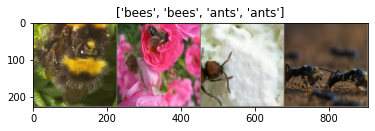

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 모델 학습하기
--------------

이제 모델을 학습하기 위한 일반 함수를 작성해보겠습니다. 여기서는 다음 내용들을
설명합니다:

-  학습률(learning rate) 관리(scheduling)
-  최적의 모델 구하기

아래에서 ``scheduler`` 매개변수는 ``torch.optim.lr_scheduler`` 의 LR 스케쥴러
객체(Object)입니다.



In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # argmax
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

### 모델 예측값 시각화하기


일부 이미지에 대한 예측값을 보여주는 일반화된 함수입니다.




In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 합성곱 신경망 미세조정(finetuning)
----------------------------------

미리 학습한 모델을 불러온 후 마지막의 완전히 연결된 계층을 초기화합니다.




In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(model_ft)
print(f'num_ftrs : {num_ftrs}')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 학습 및 평가하기

CPU에서는 15-25분 가량, GPU에서는 1분도 이내의 시간이 걸립니다.




In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.5508 Acc: 0.7377
val Loss: 0.1591 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.5690 Acc: 0.7910
val Loss: 0.3165 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.4875 Acc: 0.7992
val Loss: 0.6091 Acc: 0.7712

Epoch 3/24
----------
train Loss: 0.5296 Acc: 0.7951
val Loss: 0.3370 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.7331 Acc: 0.7664
val Loss: 0.5086 Acc: 0.8497

Epoch 5/24
----------
train Loss: 0.4974 Acc: 0.8074
val Loss: 0.4283 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.3781 Acc: 0.8484
val Loss: 0.5448 Acc: 0.7908

Epoch 7/24
----------
train Loss: 0.5023 Acc: 0.7828
val Loss: 0.2549 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3180 Acc: 0.8566
val Loss: 0.2365 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3039 Acc: 0.8770
val Loss: 0.2249 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2735 Acc: 0.8607
val Loss: 0.2425 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3434 Acc: 0.8484
val Loss: 0.2192 Acc: 0.9216

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


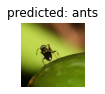

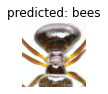

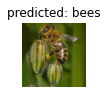

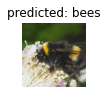

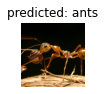

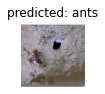

In [13]:
visualize_model(model_ft)

## 고정된 특징 추출기로써의 합성곱 신경망
---------------------------------------

이제, 마지막 계층을 제외한 신경망의 모든 부분을 고정해야 합니다.
``requires_grad == False`` 로 설정하여 매개변수를 고정하여 ``backward()`` 중에
경사도가 계산되지 않도록 해야합니다.

이에 대한 문서는
[여기](http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)
에서 확인할 수 있습니다.




In [15]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 학습 및 평가하기

CPU에서 실행하는 경우 이전과 비교했을 때 약 절반 가량의 시간만이 소요될 것입니다.
이는 대부분의 신경망에서 경사도를 계산할 필요가 없기 때문입니다. 하지만,
순전파는 계산이 필요합니다.




In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5726 Acc: 0.7008
val Loss: 0.9208 Acc: 0.5686

Epoch 1/24
----------
train Loss: 0.5681 Acc: 0.7459
val Loss: 0.2440 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.3999 Acc: 0.8238
val Loss: 0.1572 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.4648 Acc: 0.7910
val Loss: 0.1600 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.5396 Acc: 0.7377
val Loss: 0.1889 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4862 Acc: 0.7992
val Loss: 0.1901 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.5717 Acc: 0.7541
val Loss: 0.4030 Acc: 0.8301

Epoch 7/24
----------
train Loss: 0.4245 Acc: 0.8238
val Loss: 0.1928 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4182 Acc: 0.8115
val Loss: 0.1917 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3939 Acc: 0.8156
val Loss: 0.1877 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3019 Acc: 0.8607
val Loss: 0.1632 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3766 Acc: 0.8402
val Loss: 0.1793 Acc: 0.9542

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


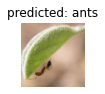

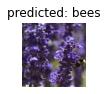

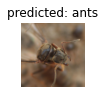

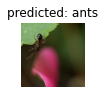

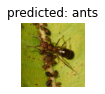

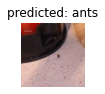

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()

더 배워볼 내용
-----------------

전이학습의 응용 사례(application)들을 더 알아보려면,
:doc:`/intermediate/quantized_transfer_learning_tutorial` 을 참조해보세요.



